In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# -*- coding: utf-8 -*-

# https://teddykoker.com/2020/12/dataloader/

import sys
sys.path.append("/home/rkube/repos/frnn-loader")

from os.path import join
from pathlib import Path

import yaml
import torch
import h5py

import matplotlib.pyplot as plt

from frnn_loader.backends.fetchers import fetcher_d3d_v1
from frnn_loader.backends.backend_hdf5 import backend_hdf5
from frnn_loader.primitives.filters import filter_ip_thresh
from frnn_loader.primitives.resamplers import resampler_causal
from frnn_loader.primitives.signal import signal_0d
from frnn_loader.primitives.normalizers import mean_std_normalizer
from frnn_loader.loaders.frnn_dataset_disk import shot_dataset_disk
from frnn_loader.loaders.frnn_multi_dataset import frnn_multi_dataset

In [3]:
"""Construct a dataset for FRNN training.

Predictive machine learning models are trained on datasets. These dataset
consist of a suite of measurements taken on a set of shots.

Deep neural networks are trained on pre-processed and normalized data.
Pre-processing includes:
- Resampling of the measurements onto a common time-base
- Construction of target variables, such as time-to-disruption or time-to-ELM
- Signal clipping
- Calculating and applying normalization

Normalization means the transformation of signals into order unity quantities. Common ways
to do this is by a Z-score transformation (subtract mean, divide by std dev.), min/max normalizer,
etc.

"""

'Construct a dataset for FRNN training.\n\nPredictive machine learning models are trained on datasets. These dataset\nconsist of a suite of measurements taken on a set of shots.\n\nDeep neural networks are trained on pre-processed and normalized data.\nPre-processing includes:\n- Resampling of the measurements onto a common time-base\n- Construction of target variables, such as time-to-disruption or time-to-ELM\n- Signal clipping\n- Calculating and applying normalization\n\nNormalization means the transformation of signals into order unity quantities. Common ways\nto do this is by a Z-score transformation (subtract mean, divide by std dev.), min/max normalizer,\netc.\n\n'

In [22]:
# Directory where all project data files are to be stored
proj_dir = "/projects/FRNN/frnn_loader"

# 1/ Describe the dataset
predictor_tags = [
    "q95",
    "efsli",
    "ipspr15V",
    "efsbetan",
    "efswmhd",
    "dusbradial",
    "dssdenest",
    "pradcore",
    "pradedge",
    "bmspinj",
    "bmstinj",
    "ipsiptargt",
    "ipeecoil",
]
predictor_list = [signal_0d(tag) for tag in predictor_tags]

# Contains a list of shots that are non-disruptive
shotlist_clear = "d3d_clear_100.txt"
# Contains a list of shots that are disruptive
shotlist_disrupt = "d3d_disrupt_100.txt"

In [23]:
# Instantiate the filter we use to crimp the shot times
ip_filter = filter_ip_thresh(0.2)
signal_ip = signal_0d("ipspr15V")
my_backend = backend_hdf5(proj_dir)
my_fetcher = fetcher_d3d_v1()

In [36]:
num_shots = 5
shotdict = {}

i = 0
with open(join(proj_dir, "..", "shot_lists", shotlist_clear), "r") as fp:
    for line in fp.readlines():
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]

        # Run the Ip filter over the current shot
        tb, data = my_backend.load(signal_ip.info, shotnr)
        tmin, tmax = ip_filter(tb, data)
        shotdict.update(
            {
                shotnr: {
                    "tmin": tmin,
                    "tmax": tmax,
                    "is_disruptive": False,
                    "t_disrupt": -1.0,
                }
            }
        )
        i += 1
        if i >= num_shots:
            break

In [37]:
i = 0
with open(join(proj_dir, "..", "shot_lists", shotlist_disrupt), "r") as fp:
    for line in fp.readlines():
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        # ttd is given in seconds in the text files. Convert it to milliseconds
        ttd = ttd * 1e3
        shotdict.update(
            {
                shotnr: {
                    "tmin": tmin,
                    "tmax": ttd,
                    "is_disruptive": True,
                    "t_disrupt": ttd,
                }
            }
        )

        i += 1
        if i >= num_shots:
            break

In [8]:
for k in shotdict.keys():
    print(shotdict[k])

{'tmin': 37.75, 'tmax': 6233.25, 'is_disruptive': False, 't_disrupt': -1.0}
{'tmin': 30.5, 'tmax': 6455.25, 'is_disruptive': False, 't_disrupt': -1.0}
{'tmin': 34.0, 'tmax': 6445.25, 'is_disruptive': False, 't_disrupt': -1.0}
{'tmin': 37.0, 'tmax': 6842.25, 'is_disruptive': False, 't_disrupt': -1.0}
{'tmin': 37.5, 'tmax': 6245.0, 'is_disruptive': False, 't_disrupt': -1.0}
{'tmin': 37.5, 'tmax': 5073.5, 'is_disruptive': True, 't_disrupt': 5073.5}
{'tmin': 37.5, 'tmax': 2159.0, 'is_disruptive': True, 't_disrupt': 2159.0}
{'tmin': 37.5, 'tmax': 5269.0, 'is_disruptive': True, 't_disrupt': 5269.0}
{'tmin': 37.5, 'tmax': 7088.0, 'is_disruptive': True, 't_disrupt': 7088.0}
{'tmin': 37.5, 'tmax': 3478.5, 'is_disruptive': True, 't_disrupt': 3478.5}


In [39]:
#########################################################################################################
#
# Next we create a list of datasets for all shots.
# The shots are cut to the time intervals defined by tmin and tmax
# A normalizer is calculated from these datasets.
# After the normalizer has been calculated the hdf5 files generated by
# these dataset are to be deleted using ds.delete_data_file

dset_unnormalized_list = []
for shotnr in shotdict.keys():

    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=proj_dir,
        download=True,
        normalizer=None,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32,
    )

    dset_unnormalized_list.append(ds)

In [40]:
dset_unnormalized_list[0].tmp_fname

'/projects/FRNN/frnn_loader/d5t4j1ka.h5'

In [41]:
#########################################################################################################
#
# With all datasets cropped to the correct time in place we continue by calculating the normalization.
# Do this using multi-processing
my_normalizer = mean_std_normalizer()
my_normalizer.fit(dset_unnormalized_list)

print(my_normalizer.mean_all)
print(my_normalizer.std_all)

tensor([ 6.2881e+00,  1.0096e+00,  1.7226e+00,  1.6998e+00,  5.6891e+05,
         9.0436e-01,  3.2198e+00,  1.5518e-03,  1.3113e-03,  5.0626e+03,
         4.0367e+00,  1.7478e+00, -2.8650e-02])
tensor([1.8086e+00, 3.4762e-01, 4.5560e-01, 1.0277e+00, 3.6443e+05, 1.0497e+00,
        1.3093e+00, 1.9447e-03, 1.0103e-03, 3.3218e+03, 2.7402e+00, 4.6416e-01,
        1.1235e-01])


In [42]:
# Print mean and standard deviation for unnormalized datasets 
for ds in dset_unnormalized_list:
    print(ds[:][0].shape, ds[:][0].mean(axis=0), ds[:][0].std(axis=0))

torch.Size([6234, 13]) tensor([ 6.2397e+00,  9.7653e-01,  1.7384e+00,  1.8166e+00,  6.2798e+05,
         8.9967e-01,  3.0376e+00,  1.8857e-03,  1.3896e-03,  5.6089e+03,
         4.3848e+00,  1.7696e+00, -3.5331e-02]) tensor([1.4428e+00, 3.8160e-01, 4.3369e-01, 1.0206e+00, 3.7188e+05, 9.9816e-01,
        1.0748e+00, 1.6551e-03, 9.2308e-04, 3.3695e+03, 2.6507e+00, 4.0958e-01,
        8.1703e-02])
torch.Size([6456, 13]) tensor([ 6.3304e+00,  9.5908e-01,  1.7055e+00,  1.7223e+00,  5.9248e+05,
         1.0999e+00,  3.5379e+00,  2.2489e-03,  1.1336e-03,  6.2639e+03,
         5.0638e+00,  1.7213e+00, -1.9438e-02]) tensor([1.3597e+00, 3.2436e-01, 4.5833e-01, 1.1209e+00, 3.8976e+05, 9.6813e-01,
        1.4991e+00, 2.3117e-03, 7.9456e-04, 4.3591e+03, 3.5988e+00, 4.7794e-01,
        3.4468e-02])
torch.Size([6446, 13]) tensor([ 6.2318e+00,  9.8198e-01,  1.7139e+00,  1.7978e+00,  6.1599e+05,
         1.0388e+00,  3.2425e+00,  1.9478e-03,  1.2806e-03,  6.1516e+03,
         4.9985e+00,  1.7236e+00, -

In [63]:
# With a normalizer at hand, we can now safely delete the datafiles from the
# un-normalized shots.
# Then re-instantiate the datasets using the trained normalizer
dset_normalized_list = []
for shotnr in shotdict.keys():
    print(shotnr)

    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=proj_dir,
        download=True,
        normalizer=my_normalizer,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32,
    )

    dset_normalized_list.append(ds)

dset_all = frnn_multi_dataset(dset_normalized_list)

167475
167481
167482
167483
167484
167480
167487
167488
167492
167494


In [ ]:
for ds in

In [44]:
dset_all[0][:]

(tensor([[ 3.2513, -0.9522, -3.7854,  ..., -1.4732, -3.7656, -0.0968],
         [ 3.2513, -0.9522, -3.7825,  ..., -1.4732, -3.7656,  0.0156],
         [ 3.2513, -0.9522, -3.7672,  ..., -1.4732, -3.7656,  0.0483],
         ...,
         [ 0.7562, -2.9044, -3.1938,  ..., -1.4732, -3.1017, -0.1069],
         [ 0.7562, -2.9044, -3.2420,  ..., -1.4732, -3.1023, -0.2999],
         [ 0.7562, -2.9044, -3.2868,  ..., -1.4732, -3.1030, -0.4787]]),
 tensor([[1.0043],
         [1.0043],
         [1.0043],
         ...,
         [1.0043],
         [1.0043],
         [1.0043]]))

In [45]:
# Verify that the returned data is about zero mean and order unity std deviation
for ds in dset_all:
    print(ds[:][0].shape, ds[:][0].mean(axis=0), ds[:][0].std(axis=0))


torch.Size([6234, 13]) tensor([-0.0267, -0.0952,  0.0347,  0.1136,  0.1621, -0.0045, -0.1391,  0.1717,
         0.0775,  0.1645,  0.1270,  0.0469, -0.0595]) tensor([0.7978, 1.0978, 0.9519, 0.9931, 1.0204, 0.9509, 0.8209, 0.8511, 0.9136,
        1.0144, 0.9674, 0.8824, 0.7272])
torch.Size([6456, 13]) tensor([ 0.0234, -0.1454, -0.0376,  0.0219,  0.0647,  0.1862,  0.2429,  0.3585,
        -0.1759,  0.3616,  0.3748, -0.0572,  0.0820]) tensor([0.7518, 0.9331, 1.0060, 1.0907, 1.0695, 0.9223, 1.1449, 1.1887, 0.7864,
        1.3123, 1.3134, 1.0297, 0.3068])
torch.Size([6446, 13]) tensor([-0.0311, -0.0795, -0.0192,  0.0953,  0.1292,  0.1281,  0.0173,  0.2036,
        -0.0305,  0.3278,  0.3510, -0.0523,  0.1358]) tensor([0.7493, 1.1101, 0.9920, 1.1733, 1.1274, 0.9080, 0.9154, 1.1008, 0.8759,
        1.2848, 1.2854, 1.0226, 0.2710])
torch.Size([6843, 13]) tensor([ 0.0513, -0.0568, -0.1926,  0.1774,  0.2087,  0.2226, -0.1236, -0.2423,
         0.3224, -0.1173, -0.1194, -0.2677,  0.3227]) tensor([0

## Plot results of normalization

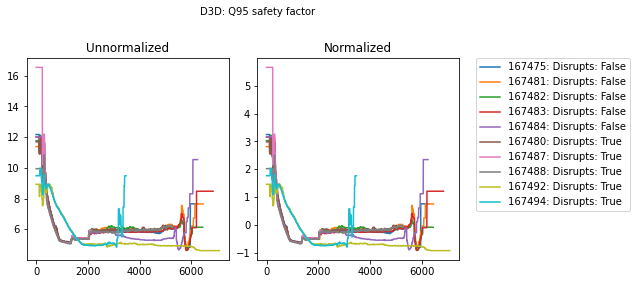

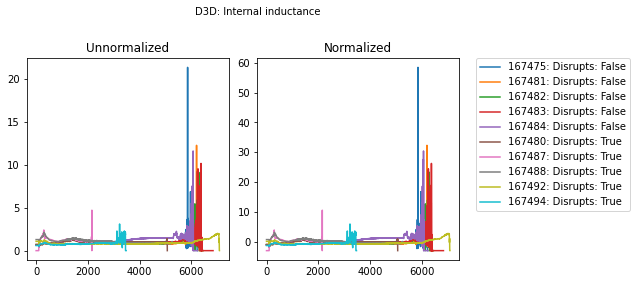

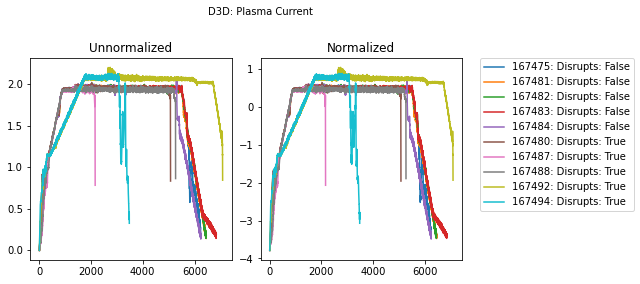

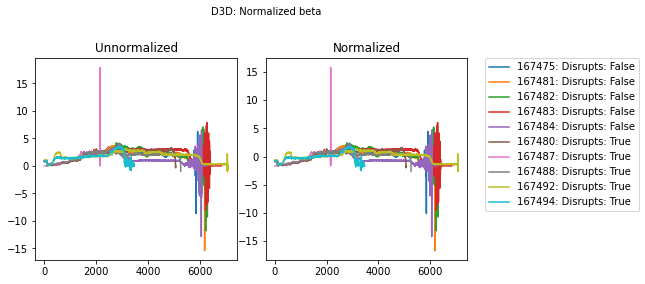

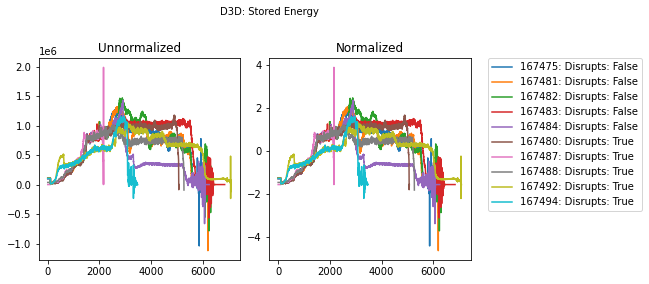

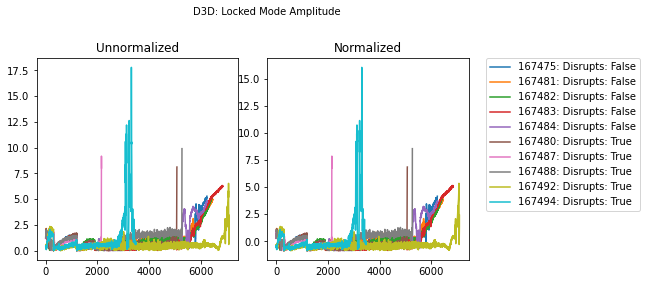

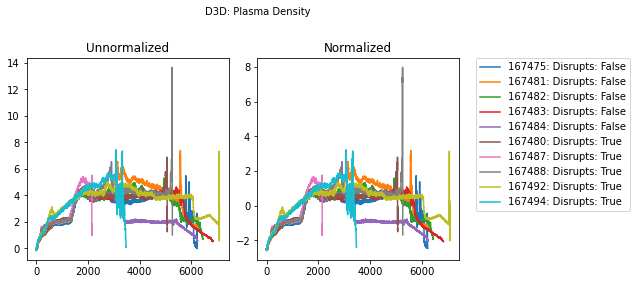

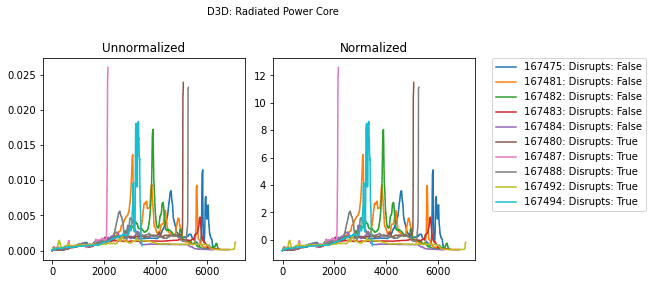

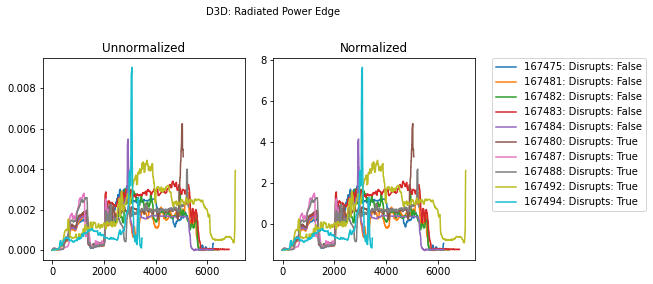

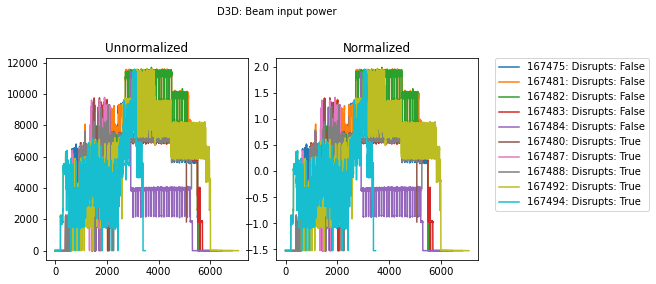

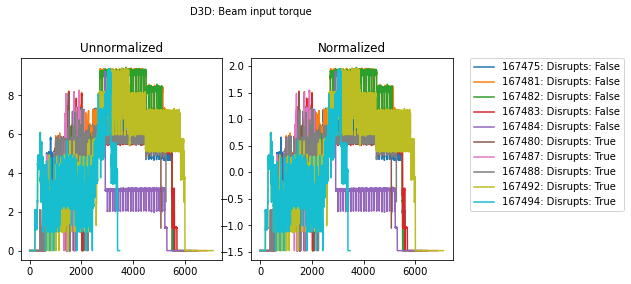

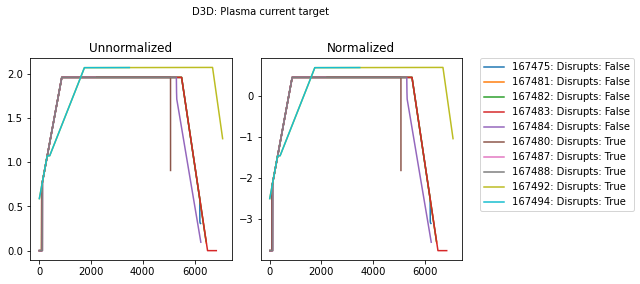

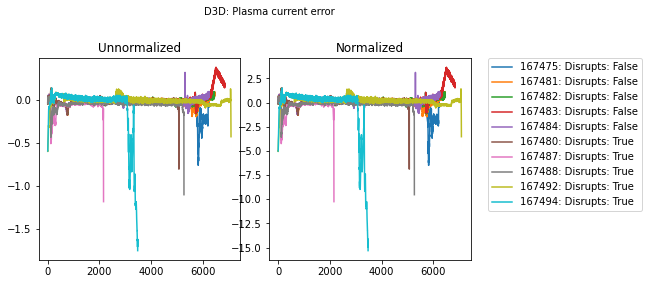

In [66]:
for i in range(13):
    fig = plt.figure(figsize=(8, 4))

    ax_u = fig.add_axes([0.1, 0.1, 0.35, 0.7])
    ax_n = fig.add_axes([0.5, 0.1, 0.35, 0.7])

    fig.text(0.5, 0.95, dset_unnormalized_list[0].predictors[i], ha="center")

    ax_u.set_title("Unnormalized")
    for ds in dset_unnormalized_list:
        label = f"{ds.shotnr}: Disrupts: {ds.is_disruptive}"
        ax_u.plot(ds[:][0][:, i], label=label)

    ax_n.set_title("Normalized")
    for ds in dset_all:
        label = f"{ds.shotnr}: Disrupts: {ds.is_disruptive}"
        ax_n.plot(ds[:][0][:, i], label=label)
    ax_n.legend(loc="upper right", bbox_to_anchor=(1.85, 1), borderaxespad=0.)

# Paths

The basis path where all data is searched for is given by conf["paths"]["fs_path"]. 

Directories that are searched for signals are given by conf["paths"]["signal_prepath"]





In [ ]:
my_conf

In [ ]:
my_conf["paths"]